In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained ResNet50 model with ImageNet weights
model = ResNet50(weights='imagenet')
model.trainable = False  

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
def preprocess_image(image_path):
    # Open and resize the image
    image = Image.open(image_path).convert('RGB').resize((224, 224))

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Preprocess the image using ResNet's preprocessing method
    image_array = preprocess_input(image_array)

    # Add batch dimension (1, 224, 224, 3)
    image_tensor = np.expand_dims(image_array, axis=0)

    return image_tensor


In [7]:
def occlude_and_predict(model, image_tensor, occlusion_size=30, stride=10):
    
    _, h, w, _ = image_tensor.shape
    output_map = np.zeros((h, w))  

    
    original_output = model.predict(image_tensor, verbose=0) 
    original_probabilities = tf.nn.softmax(original_output, axis=-1).numpy()

    # Get the predicted class (highest probability)
    predicted_class = np.argmax(original_probabilities)

    # Iterate over the image with the occlusion square
    for y in range(0, h - occlusion_size + 1, stride):
        for x in range(0, w - occlusion_size + 1, stride):
    
            occluded_image = image_tensor.copy()

            occluded_image[:, y:y + occlusion_size, x:x + occlusion_size, :] = 0

            output = model.predict(occluded_image, verbose=0) 
            probabilities = tf.nn.softmax(output, axis=-1).numpy()

            # Store the probability of the predicted class for the occluded region
            output_map[y:y + occlusion_size, x:x + occlusion_size] = probabilities[0, predicted_class]

    return output_map, predicted_class


In [8]:
def show_saliency_map(output_map, image_path):
    # Open the image again to visualize
    image = Image.open(image_path).convert('RGB')

    plt.figure(figsize=(10, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")

    # Plot the saliency map with 'jet' color mapping
    plt.subplot(1, 2, 2)
    plt.imshow(output_map, cmap='jet', interpolation='nearest')
    plt.title("Occlusion-Based Saliency Map")
    plt.colorbar()  # Add color bar to indicate probability values
    plt.show()


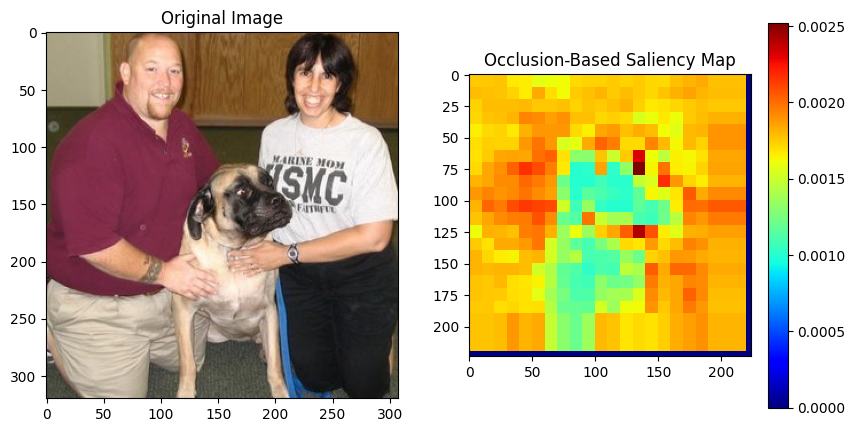

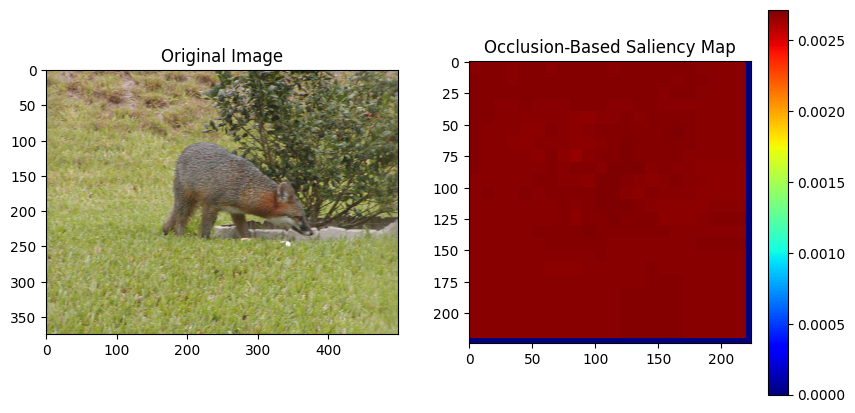

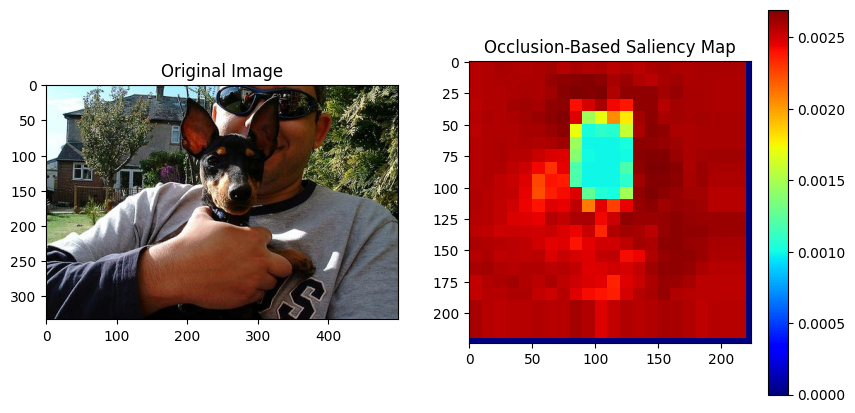

In [9]:
occlusion_size = 30  # Size of the occluding square (increased for better occlusion)
stride = 10  # Stride of the occluding square

path = '/kaggle/input/images1/'

# Loop through a set of images and generate occlusion-based saliency maps
for item in ['bull_mastiff.JPEG', 'grey_fox.JPEG', 'toy_terrier.JPEG']:
    image_tensor = preprocess_image(path + item)

    # Run occlusion prediction and generate the output map
    output_map, predicted_class = occlude_and_predict(model, image_tensor, occlusion_size, stride)

    # Show the saliency map for the test image
    show_saliency_map(output_map, path + item)


* First Image (People with a Dog): The model correctly focuses on the dog's head and hand, showing it identifies the relevant parts of the image for classification.

* Second Image (Animal in Grass): The model struggles, with the saliency map uniformly red, indicating it isn't focusing on the animal or any specific part of the image. This suggests confusion, likely due to the background blending with the subject.

* Third Image (Person Holding a Dog): The model accurately focuses on the dog’s head, indicating good classification performance for the main object.